In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import scipy.stats as st
from statsmodels.stats.multitest import multipletests
from permute.core import two_sample
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sklearn
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 4)

import warnings
warnings.filterwarnings("ignore")

In [2]:
#функция, обучающая классификатор на заданной выборке и возвращающая accuracy, roc_auc_score
def learn(X, y, classifier):
    
    (X_train, X_test,
     y_train, y_test) = train_test_split(X, y, random_state=0, stratify=y, test_size=0.5)
    
    clf = classifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    return accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred)

In [3]:
# функция, запустить обучение каждой из моделей двухклассовой классификации 
# на всех возможных парах классов из определенного датасета
# возвращает массивы accuracy, roc_auc_score
def process(data):
    
    clf_dict = {'logisitc':LogisticRegression, 'tree':DecisionTreeClassifier,
                'knn':KNeighborsClassifier, 'svc':SVC}
    
    clf_accuracy = []
    clf_roc_auc = []
    
    X = scale(data.data)
    y = data.target
    classes = np.unique(y)
    for i in range(len(classes)):
        for j in range(i+1, len(classes)):
            X_sub = X[np.logical_or(y==i, y==j)]
            y_sub = y[np.logical_or(y==i, y==j)]
            
            clf_accuracy.append([])
            clf_roc_auc.append([])
            for clf in clf_dict.keys():
                acc, roc_auc = learn(X_sub, y_sub, clf_dict[clf])
                clf_accuracy[-1].append(acc)
                clf_roc_auc[-1].append(roc_auc)
                       
    return clf_accuracy, clf_roc_auc

Получим значения accuracy и roc_auc классификаторов для всех пар выборок.

In [4]:
accuracy = []
roc_auc = []
for load in [datasets.load_breast_cancer, datasets.load_iris, 
             datasets.load_wine, datasets.load_digits]:
    data = load()
    acc, auc = process(data)
    accuracy += acc
    roc_auc += auc

In [5]:
clf_names = ['logistic', 'tree', 'knn', 'svc']
accuracy = pd.DataFrame(np.array(accuracy), columns=clf_names)
roc_auc = pd.DataFrame(np.array(roc_auc), columns=clf_names)

In [6]:
accuracy.head()

,logistic,tree,knn,svc
0,0.978947,0.922807,0.961404,0.968421
1,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000
3,0.980000,0.980000,0.960000,0.980000
4,0.984615,0.923077,0.953846,1.000000


In [7]:
roc_auc.head()

,logistic,tree,knn,svc
0,0.979393,0.917387,0.953884,0.967166
1,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000
3,0.980000,0.980000,0.960000,0.980000
4,0.985714,0.926190,0.957143,1.000000


Определим, есть ли классификаторы, дающие наилучший ROC-AUC или точность среди остальных. Для этого выдвинем гипотезу:

$$H_0 : \mathbb{E}X_i \geq \mathbb{E}X_j, ~i\neq j$$

Если гипотеза не отвергается для определенного $i$ для всех $j$, то будем, считать, что данные не противоречат тому, что классификатор $i$ может быть лучшим, иначе - он не может быть лучшим.

##### Двухвыборочный перестановочный критерий.

Построим гистограммы распределений попарных разностей.

1) Для точности:

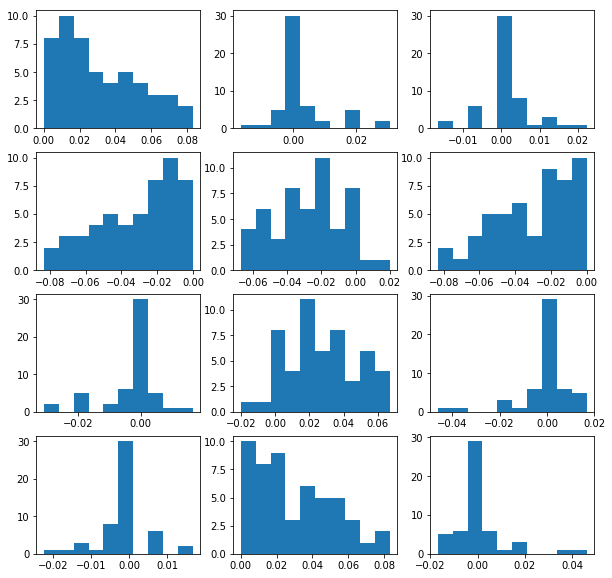

In [8]:
fig, axs = plt.subplots(4, 3, figsize=(10,10))
for i, c1 in enumerate(clf_names):
    
    j = 0
    for c2 in clf_names:
        if c1 != c2:
            axs[i][j].hist(accuracy[c1]-accuracy[c2])
            j += 1
plt.show()

1) Для roc-auc-score:

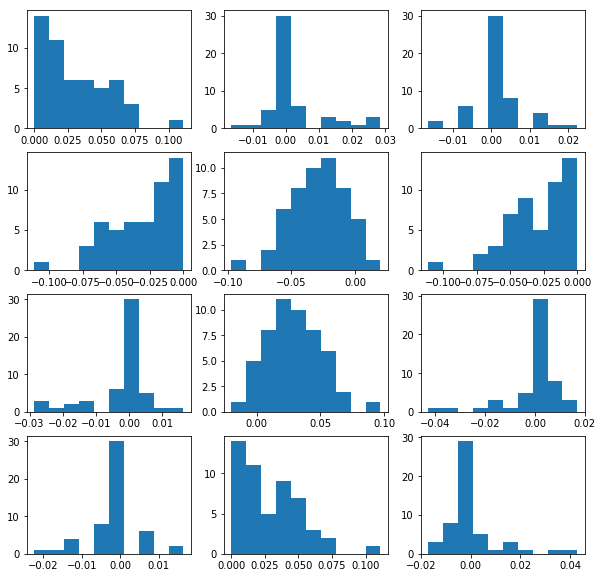

In [9]:
fig, axs = plt.subplots(4, 3, figsize=(10,10))
for i, c1 in enumerate(clf_names):
    
    j = 0
    for c2 in clf_names:
        if c1 != c2:
            axs[i][j].hist(roc_auc[c1]-roc_auc[c2])
            j += 1
plt.show()

Из графиков видно, что распределение разностей связанных выборок несимметрично, поэтому двухвыборочный перестановочный критерий не рекомендуется использовать, но все равно его применим и посмотрим, что  получится.

In [10]:
p_acc = []
p_roc = []
for c1 in clf_names:
    p_acc.append([])
    p_roc.append([])
    for c2 in clf_names:
        if c1 != c2:
            acc_result = two_sample(accuracy[c1], accuracy[c2], alternative='less')
            roc_result = two_sample(roc_auc[c1], roc_auc[c2], alternative='less')
            p_acc[-1] += [acc_result[0]]  
            p_roc[-1] += [roc_result[0]]  

In [11]:
pd.DataFrame(np.array(p_acc), clf_names)

,0,1,2
logistic,1.00000,0.91208,0.79124
tree,0.00000,0.00000,0.00000
knn,0.08561,1.00000,0.21479
svc,0.20673,1.00000,0.78489


In [12]:
pd.DataFrame(np.array(p_roc), clf_names)

,0,1,2
logistic,1.00000,0.9181,0.80467
tree,0.00000,0.0000,0.00000
knn,0.08133,1.0000,0.21841
svc,0.19629,1.0000,0.78127


In [13]:
for i in range(4):
    rejections = multipletests(p_acc[i], method='holm')[0].sum()
    if rejections > 0:
        print('H0 is rejected for', clf_names[i])

H0 is rejected for tree


In [14]:
for i in range(4):
    rejections = multipletests(p_roc[i], method='holm')[0].sum()
    if rejections > 0:
        print('H0 is rejected for', clf_names[i])

H0 is rejected for tree


##### Критерий Манна-Уитни-Уилкоксона

In [15]:
p_acc = []
p_roc = []
for c1 in clf_names:
    p_acc.append([])
    p_roc.append([])
    for c2 in clf_names:
        if c1 != c2:
            acc_result = st.mannwhitneyu(accuracy[c1], accuracy[c2], alternative='less')
            roc_result = st.mannwhitneyu(roc_auc[c1], roc_auc[c2], alternative='less')
            p_acc[-1] += [acc_result[1]]  
            p_roc[-1] += [roc_result[1]]  

In [16]:
pd.DataFrame(np.array(p_acc), clf_names)

,0,1,2
logistic,1.000000e+00,8.461095e-01,9.226180e-01
tree,7.423870e-13,1.025274e-10,8.427178e-12
knn,1.556123e-01,1.000000e+00,6.214748e-01
svc,7.841335e-02,1.000000e+00,3.811718e-01


In [17]:
pd.DataFrame(np.array(p_roc), clf_names)

,0,1,2
logistic,1.000000e+00,8.274667e-01,9.107444e-01
tree,4.268193e-13,1.001664e-10,6.867308e-12
knn,1.743879e-01,1.000000e+00,6.411819e-01
svc,9.040386e-02,1.000000e+00,3.614201e-01


In [18]:
for i in range(4):
    rejections = multipletests(p_acc[i], method='holm')[0].sum()
    if rejections > 0:
        print('H0 is rejected for', clf_names[i])

H0 is rejected for tree


In [19]:
for i in range(4):
    rejections = multipletests(p_roc[i], method='holm')[0].sum()
    if rejections > 0:
        print('H0 is rejected for', clf_names[i])

H0 is rejected for tree


#### Вывод:

По результатам, полученным с помощью двухвыборочного перестановочного критерия и критерия Манна-Уитни-Уилкоксона, получаем, что классификаторы Tree не являются лучшими классификаторами по точности и roc-auc-score.

Полученные данные не противоречат тому, что logistic, tree и knn могут быть лучшими классификаторами.